In [ ]:
from vocab import Vocabulary
import evaluation
#evaluation.evalrank("$RUN_PATH/coco_vse++/model_best.pth.tar", data_path="$DATA_PATH", split="test")
#evaluation.evalrank("data/runs/coco_vse++/model_best.pth.tar", data_path="data/", split="test", on_gpu=True)
evaluation.evalrank("data/runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar", data_path="data/", split="test", on_gpu=True, image_location="/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/val2014/", fold5=True)

In [ ]:
from vocab import Vocabulary
import evaluation
#evaluation.evalrank("$RUN_PATH/coco_vse++/model_best.pth.tar", data_path="$DATA_PATH", split="test")
#evaluation.evalrank("data/runs/coco_vse++/model_best.pth.tar", data_path="data/", split="test", on_gpu=True)
evaluation.evalrank("data/runs/coco_vse++_resnet_restval_finetune/model_best.pth.tar", data_path="data/", split="test", on_gpu=True, image_location="/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/val2014/", fold5=False)

In [1]:
from __future__ import print_function
import os
import pickle

import numpy
from data import get_test_loader
import time
import numpy as np
from vocab import Vocabulary  # NOQA
import torch
from model import VSE, order_sim
from collections import OrderedDict

from evaluation import encode_data

In [2]:
def t2i(images, captions, npts=None, return_ranks=False):
    """
    Text->Images (Image Search)
    Images: (5N, K) matrix of images
    Captions: (5N, K) matrix of captions
    """
    if npts is None:
        npts = int(images.shape[0] / 5)
        print(npts)
    ims = numpy.array([images[i] for i in range(0, len(images), 5)])

    ranks = numpy.zeros(5 * npts)
    
    top1 = numpy.zeros(5 * npts)
    for index in range(npts):

        # Get query captions
        queries = captions[5 * index:5 * index + 5]

        # Compute scores
        d = numpy.dot(queries, ims.T)
        inds = numpy.zeros(d.shape)
        for i in range(len(inds)):
            inds[i] = numpy.argsort(d[i])[::-1]
            ranks[5 * index + i] = numpy.where(inds[i] == index)[0][0]
            top1[5 * index + i] = inds[i][0]

    # Compute metrics
    r1 = 100.0 * len(numpy.where(ranks < 1)[0]) / len(ranks)
    r5 = 100.0 * len(numpy.where(ranks < 5)[0]) / len(ranks)
    r10 = 100.0 * len(numpy.where(ranks < 10)[0]) / len(ranks)
    medr = numpy.floor(numpy.median(ranks)) + 1
    meanr = ranks.mean() + 1
    if return_ranks:
        return (r1, r5, r10, medr, meanr), (ranks, top1)
    else:
        return (r1, r5, r10, medr, meanr)

In [3]:
#model_path="data/runs/coco_vse++/model_best.pth.tar"
model_path="data/runs/coco_vse++_resnet_restval/model_best.pth.tar"
image_path="/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/val2014/"
data_path="data/"
vocab_path="vocab/"
split="test"
on_gpu=True

In [4]:
device = 'cpu' if not on_gpu else 'cuda'
checkpoint = torch.load(model_path, map_location=torch.device(device))
opt = checkpoint['opt']

In [5]:
opt

Namespace(Diters=5, Gimage_size=32, Giters=1, batch_size=128, beta1=0.9, beta2=0.999, betas=(0.9, 0.999), clamp_lower=-0.01, clamp_upper=0.01, cnn_type='resnet152', crop_size=224, data_name='coco', embed_size=1024, eta=1.0, eta_m=1.0, finetune=False, gamma=0.1, grad_clip=2.0, img_dim=4096, learning_rate=0.0002, log_step=10, logger_name='runs/coco_uvs_resnet_restval_l2norm', lr_update=15, margin=0.2, max_violation=True, measure='cosine', model_name='UVS', model_path='./model/', ndf=64, no_imgnorm=False, no_prel2norm=False, noadam=False, nol2norm=False, num_epochs=30, num_layers=1, resume='', save_step=1000, txt_dim=6000, use_abs=False, use_mask=False, use_restval=True, val_step=500, vocab_path='./data/', vocab_size=11755, word_dim=300, workers=10)

In [6]:
if data_path is not None:
    opt.data_path = data_path

if vocab_path is not None:
    opt.vocab_path = vocab_path

# load vocabulary used by the model
with open(os.path.join(opt.vocab_path,
                       '%s_vocab.pkl' % opt.data_name), 'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

# construct model
model = VSE(opt)

# load model state
model.load_state_dict(checkpoint['model'])

print('Loading dataset')
data_loader = get_test_loader(split, opt.data_name, vocab, opt.crop_size,
                              opt.batch_size, opt.workers, opt, 
                              image_location=image_path,
                              caption_file='/home/vu48pok/Downloads/outfile.json'
                             )

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
0:00:00.055546
creating index...
index created!


In [8]:
print('Computing results...')
img_embs, cap_embs = encode_data(model, data_loader, on_gpu=on_gpu)
print('Images: %d, Captions: %d' %
      (img_embs.shape[0] / 5, cap_embs.shape[0]))

Computing results...
Images: 1000, Captions: 5000


In [10]:
print(img_embs.shape)
print(cap_embs.shape)

(5000, 1024)
(5000, 1024)


In [30]:
import pandas as pd
from scipy.spatial.distance import cosine

ann_df = pd.DataFrame(data_loader.dataset.coco[0].anns).T.set_index('id')

idx2imgid = ann_df['image_id'].to_dict()
imgid2idx = {v: k for k, v in idx2imgid.items()}

all_ranks = np.zeros((len(cap_embs), 4))

for i in range(len(cap_embs)):
    cemb = cap_embs[i]
    target = ann_df.loc[i].image_id
    distractors = ann_df.loc[i].distractors
    idx_array = np.array([imgid2idx[j] for j in [target]+distractors])
    iemb = img_embs[idx_array]
    
    cosines = np.zeros((len(iemb), 1))
    for j in range(len(iemb)):
        cosines[j] = cosine(cemb, iemb[j])
    ranks = np.argsort(cosines.ravel())
    all_ranks[i] = ranks
    
target_positions = np.where(all_ranks==0)[1]

acc = len(target_positions[target_positions == 0]) / len(target_positions)

print(acc)

0.8372


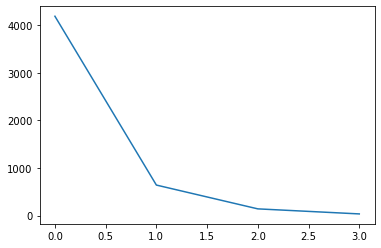

In [31]:
import matplotlib.pyplot as plt
from collections import Counter
counts = Counter(target_positions)
keys = sorted(counts.keys())
values = [counts[k] for k in keys]
plt.plot(keys, values)